In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml
import wandb

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/wandb/util.py:35: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence


In [3]:
predictions_dict = {}

In [4]:
config_filename = 'default.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [5]:
timestamp = datetime.datetime.now()
output_folder = '../../misc/reports/{}'.format(timestamp.strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

In [34]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.usetex': False,
    'font.size': 12,
    'font.family': 'Palatino',
})

In [7]:

# scenario_dict ={}   
# for i in range(7):
#     file_name = '../../misc/predictions/exp_{}.pickle'.format(i)
#     with open(file_name, 'rb') as handle:
#         PD = pkl.load(handle)
#     scenario_dict['exp'+str(i)] = PD['m1']
# with open('../../misc/predictions/scenario_dict.pickle', 'wb') as handle:
#     pkl.dump(scenario_dict, handle)

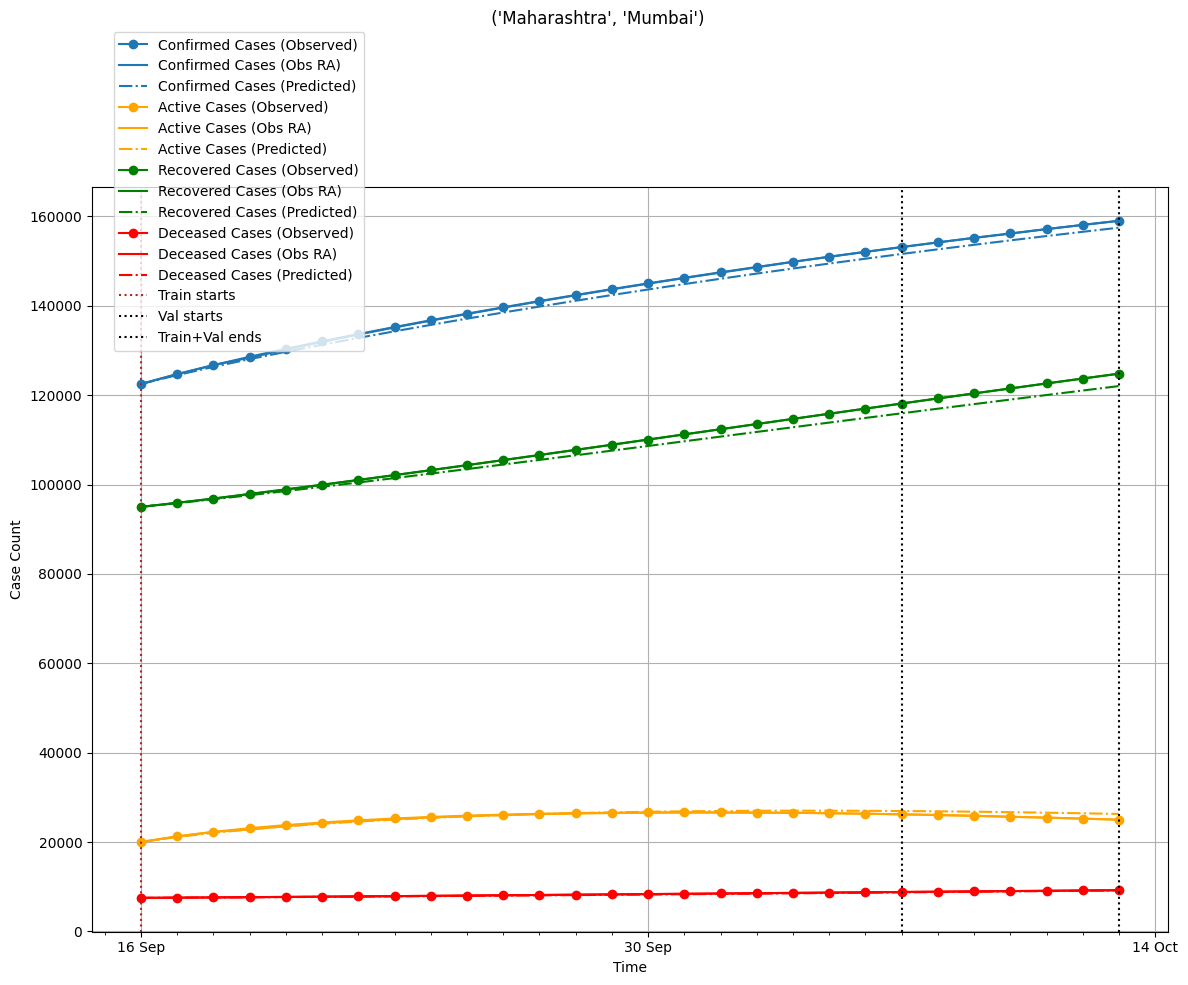

In [31]:
import pickle as pkl
with open('../../misc/predictions/exp_11.pickle', 'rb') as handle:
        PD = pkl.load(handle)

{}

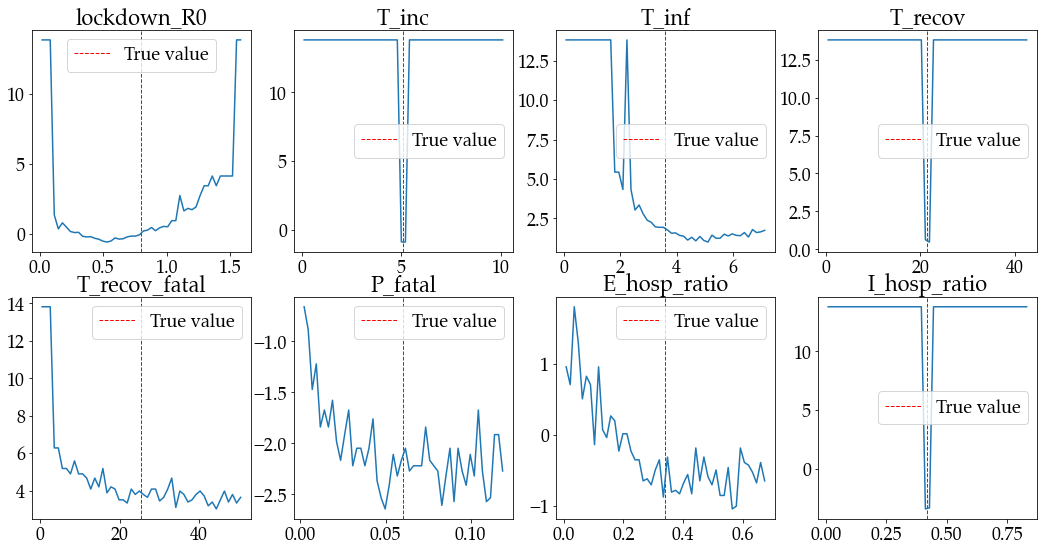

In [32]:
figs, axs = plt.subplots(2,4,figsize = [18,9])
from viz.fit import plot_histogram,plot_all_histogram,plot_2_histogram,plot_log_density
true_val  = {"lockdown_R0": 0.8,
    "T_inc": 5.1,
    "T_inf": 3.6,
    "T_recov": 21.5,
    "T_recov_fatal": 25.5 ,
    "P_fatal": 0.06,
    "E_hosp_ratio": 0.34,
    "I_hosp_ratio": 0.42}
arr = list(true_val.keys())
# arr = ['I_hosp_ratio','T_inc','E_hosp_ratio','T_inf']
plot_log_density(PD['m1'],arr,true_val,figs,axs)

{}

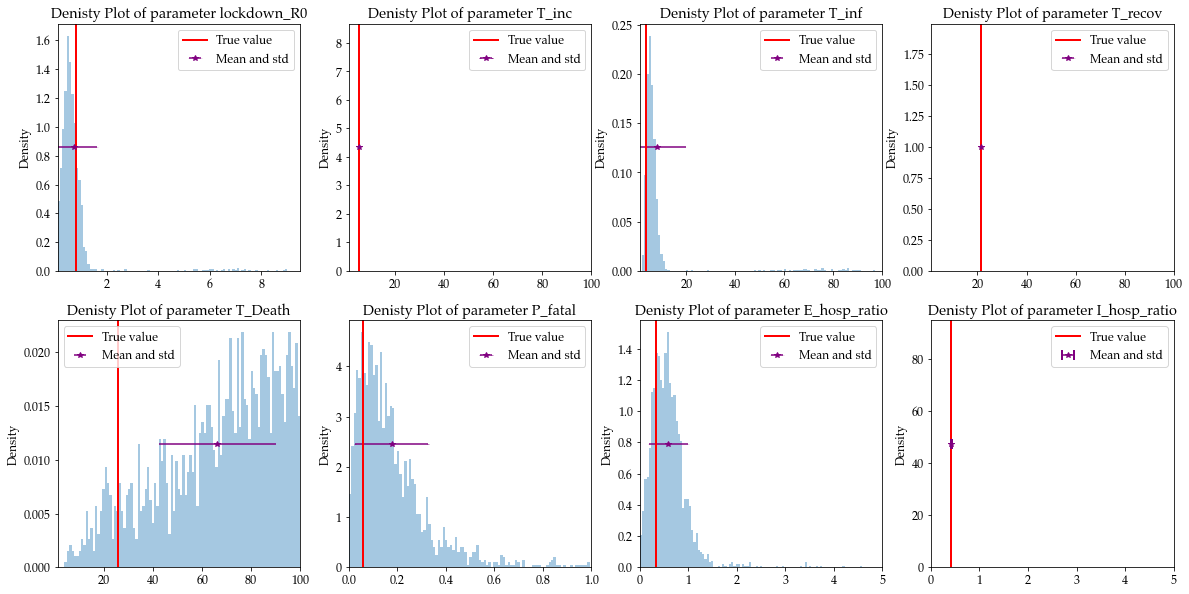

In [35]:
figs, axs = plt.subplots(2,4,figsize = [20,10])
plot_histogram(PD['m1'],arr,true_val,figs,axs)

In [24]:
from unidip import UniDip
import pandas as pd
arr = list(true_val.keys())

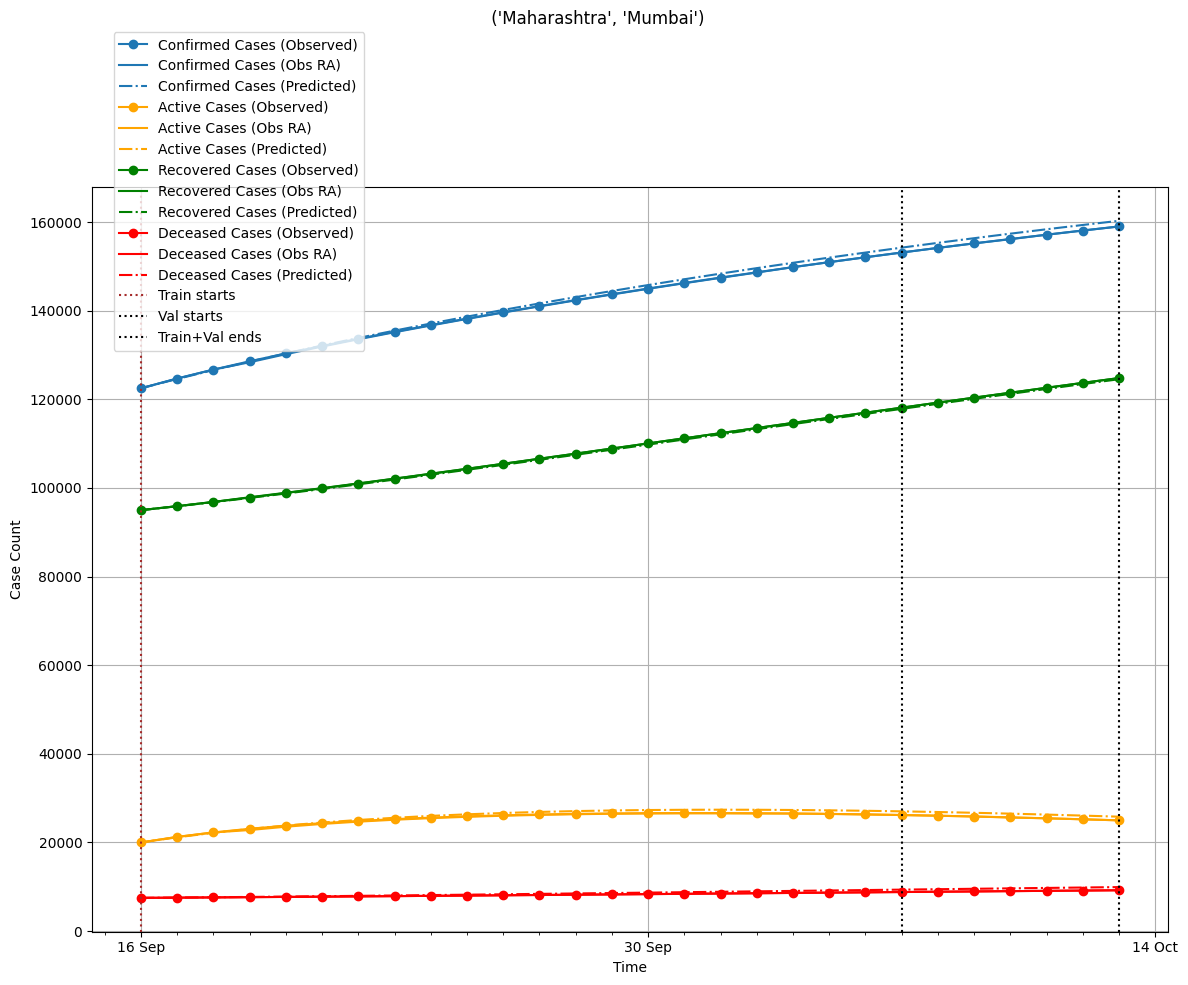

In [28]:

import pickle as pkl
with open('../../misc/predictions/exp_11.pickle', 'rb') as handle:
        PD = pkl.load(handle)
from main.seir.forecast import _order_trials_by_loss
params_array, losses_array = _order_trials_by_loss(PD['m1'])
params_dict = {param: [param_dict[param] for param_dict in params_array]
                for param in arr}
df = pd.DataFrame.from_dict(params_dict)


In [29]:
plt.rcParams.update({
    'text.usetex': False,
    'font.size': 18,
    'font.family': 'Palatino',
})

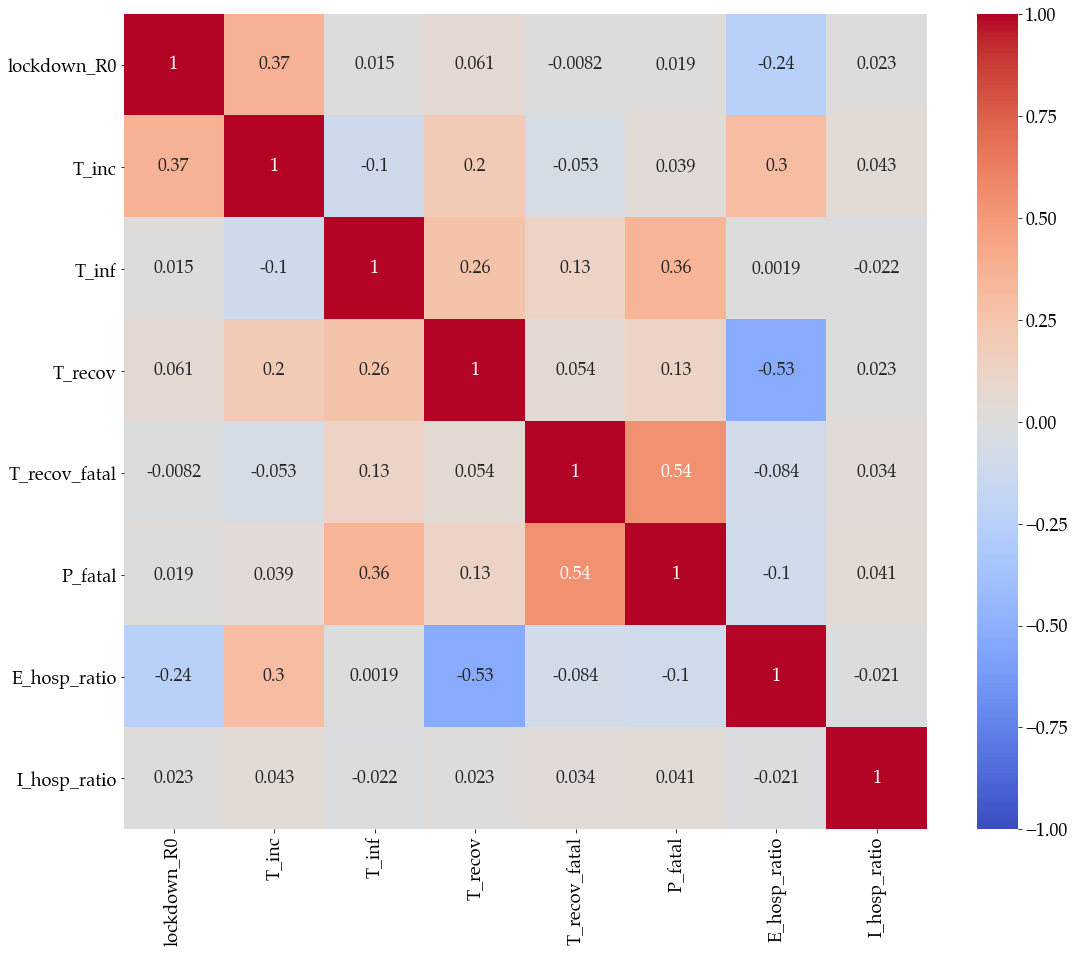

In [30]:
import seaborn as sns
CM = df.corr()
fig = plt.figure(figsize = (18,15))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap = 'coolwarm')

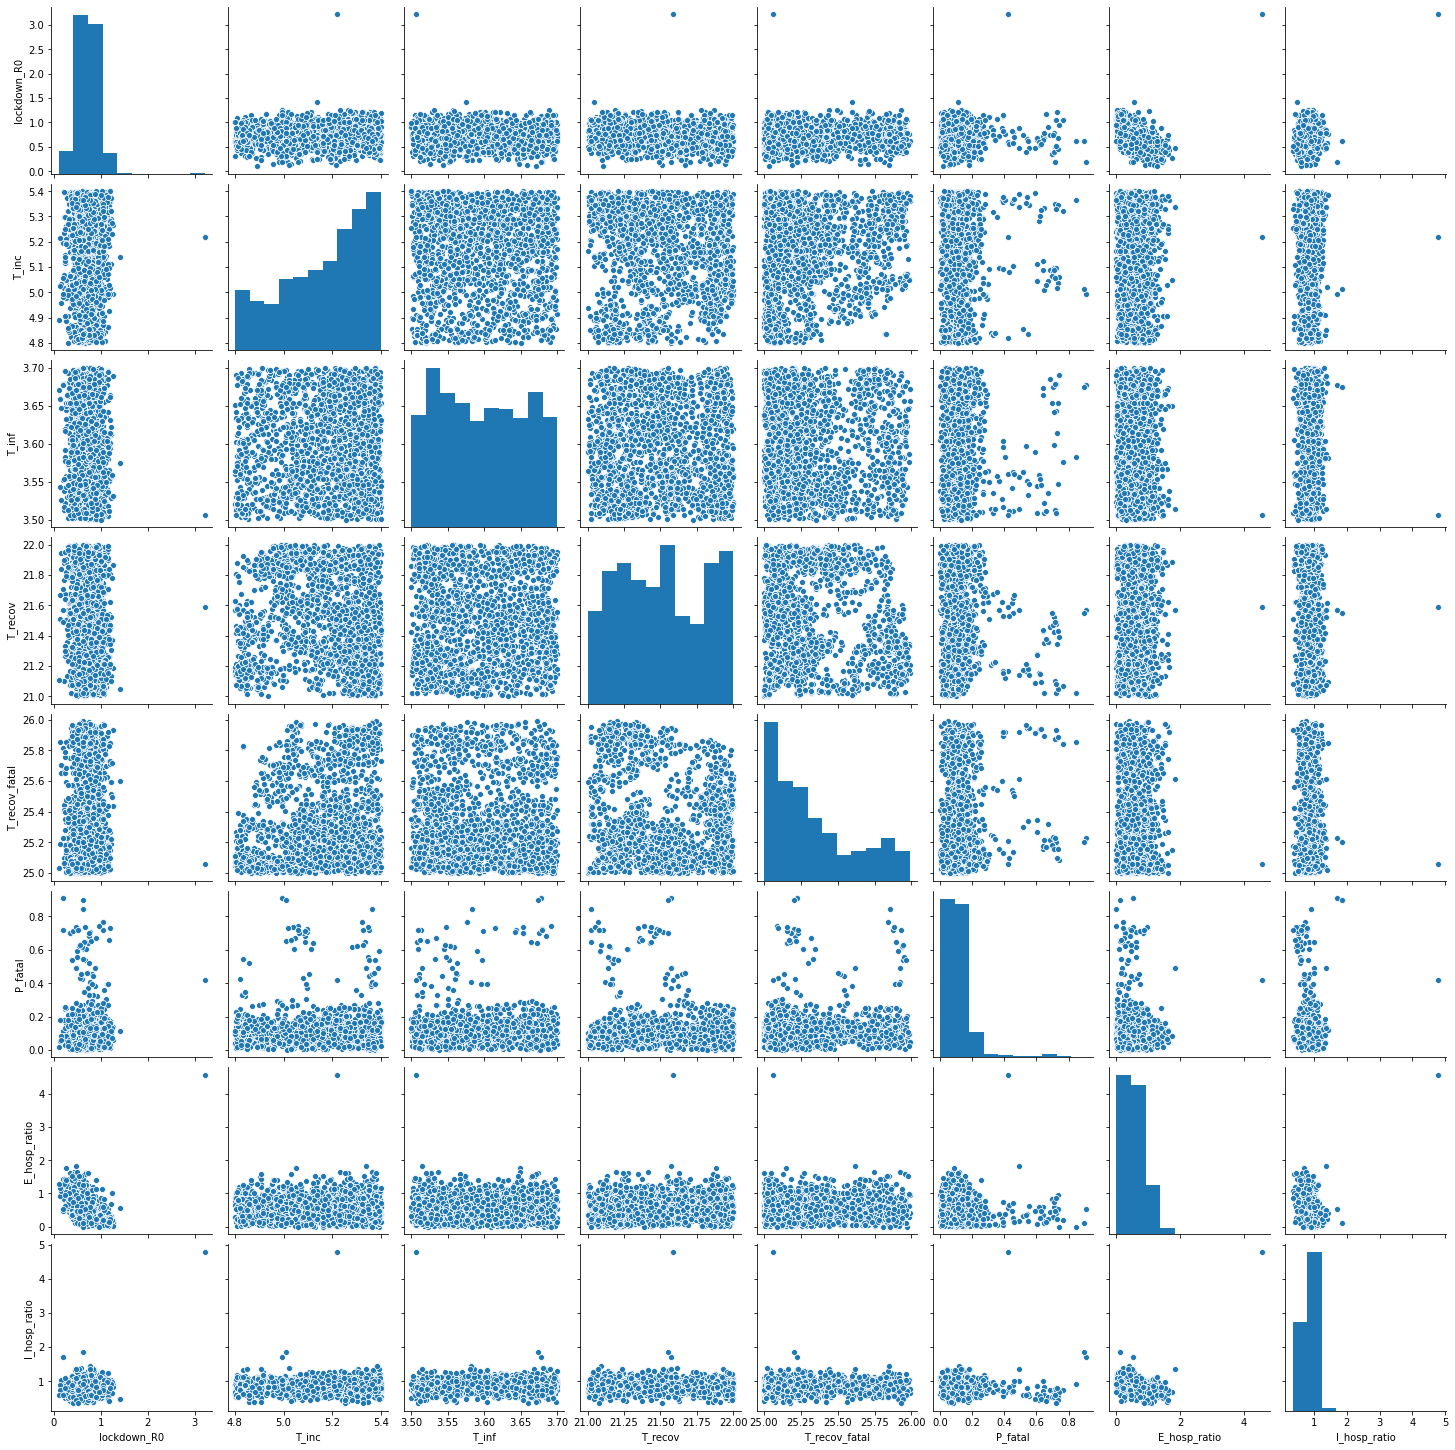

In [12]:
sns.pairplot(df)

In [76]:
((CM.abs().mean()*8 - 1)/7).sort_values(ascending = False)

I_hosp_ratio     0.298519
T_inf            0.281245
E_hosp_ratio     0.216015
T_recov          0.155864
P_fatal          0.147903
T_recov_fatal    0.129751
lockdown_R0      0.127069
T_inc            0.125674
dtype: float64

In [11]:
# for i in arr:
#     R_0 = df[i].to_numpy()
#     R_0 = np.msort(R_0)
#     interavals = UniDip(R_0,alpha=0.0000001, ntrials=1000).run()
#     print(i,interavals)

Performing m1 fit ..
pulling from source
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 181                 | 182                 | 183                 | 184                 | 185                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-24 00:00:00 | 2020-10-25 00:00:00 | 2020-10-26 00:00:00 | 2020-10-27 00:00:00 | 2020-10-28 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 249759.14           | 250955.0            | 252085.0            | 252886.0            | 254240.0            |
| active      | 18795.86          

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


100%|██████████| 2000/2000 [01:26<00:00, 23.09trial/s, best loss: 1.0728316738287107]
best parameters
 {'E_hosp_ratio': 0.11617444422010248, 'I_hosp_ratio': 0.5288899073382856, 'P_fatal': 0.05632727017853305, 'T_inc': 3.535198765377239, 'T_inf': 4.88528809188572, 'T_recov': 10.51839660251352, 'T_recov_fatal': 39.92667516155351, 'lockdown_R0': 0.8188161764770826}
CPU times: user 5min 21s, sys: 23.5 s, total: 5min 45s
Wall time: 6min 17s


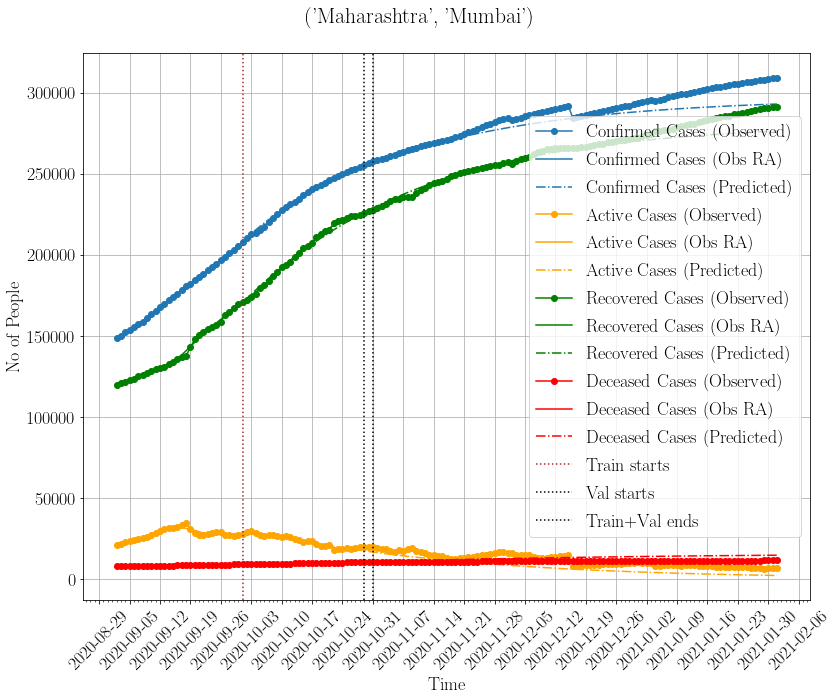

In [44]:
%%time
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting']))

Performing m2 fit ..
loading from ../../misc/cache/dataframes_ts_07022021_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 184                 | 185                 | 186                 | 187                 | 188                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-27 00:00:00 | 2020-10-28 00:00:00 | 2020-10-29 00:00:00 | 2020-10-30 00:00:00 | 2020-10-31 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 253202.29           | 254264.86           | 255360.0            | 256505.0            | 257497.0   

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


100%|██████████| 2000/2000 [01:32<00:00, 21.59trial/s, best loss: 1.283881739765071] 
best parameters
 {'E_hosp_ratio': 0.25330324926430653, 'I_hosp_ratio': 0.451479600736931, 'P_fatal': 0.055710589284031706, 'T_inc': 3.4314124264645116, 'T_inf': 5.072768525576489, 'T_recov': 9.907970547882261, 'T_recov_fatal': 39.95665045402437, 'lockdown_R0': 0.7520150593813448}


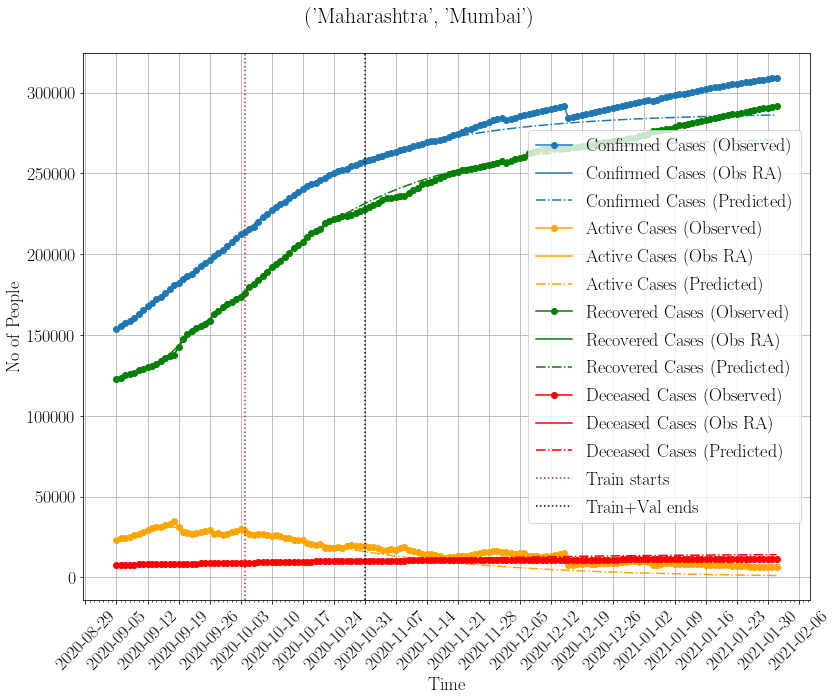

In [45]:
m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = timestamp.strftime("%Y-%m-%d")

In [30]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.1969205100065506,
 'I_hosp_ratio': 0.34308912419417364,
 'P_fatal': 0.02581825771313749,
 'T_inc': 4.7708319762045726,
 'T_inf': 3.8494050066274985,
 'T_recov': 11.844334672460917,
 'T_recov_fatal': 16.108142640399176,
 'lockdown_R0': 0.9425943707255837}

In [26]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.09258571007084876,
 'I_hosp_ratio': 0.2737746626256813,
 'P_fatal': 0.033513839997510245,
 'T_inc': 3.0408584999786603,
 'T_inf': 3.2415694090322384,
 'T_recov': 11.337958162055434,
 'T_recov_fatal': 22.284204772029245,
 'lockdown_R0': 0.9988561056462735}

## Loss Dataframes

### M1 Loss DataFrame

In [31]:
predictions_dict['m1']['df_loss']

,train,val,test
total,1.21768,0.911845,1.12282
active,4.71829,4.36092,8.44281
recovered,1.41679,0.6519,0.894086
deceased,0.203301,0.0878734,1.98979


### M2 Loss DataFrame

In [28]:
predictions_dict['m2']['df_loss']

,train,test
total,1.14777,2.19138
active,4.50728,13.6951
recovered,1.25228,1.53852
deceased,0.20956,4.10564


## Sensitivity Plot

In [ ]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [ ]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 'test', 
                                                                 error_bars=False)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [ ]:
config = read_config(config_filename)

In [ ]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                    'forecast_config': config['forecast'], **config['uncertainty']['uncertainty_params']}
                    
uncertainty = config['uncertainty']['method'](**uncertainty_args)

In [ ]:
uncertainty.ensemble_mean_forecast['df_loss']

In [ ]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [ ]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

In [ ]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 48.7804878], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80.48780488], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 48.7804878], error_bars=False)

In [ ]:
config['forecast']['plot_ptiles_for_columns']

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Log on MLFlow

In [ ]:
a = {1:[2,3],2:[3,4],3:[4,5]}
b = {1:[4,5],2:[5,6],3:[7,8]}

In [ ]:
a.update(b)

In [ ]:
a


In [ ]:
log_mlflow(config['logging']['experiment_name'], run_name=config['logging']['run_name'], artifact_dir=output_folder)